# CRITEO SPONSORED SEARCH CONVERSION LOG DATASET

## WHAT IS THIS NOTEBOOK ABOUT

This notebook presents EDA (Exploratory Data Analysis), elements of feature engineering and statistical testing of the "CRITEO SPONSORED SEARCH CONVERSION LOG DATASET"

## CONTENTS

1. [INTRODUCTION](#1.-INTRODUCTION)
2. [EXPLORATORY DATA ANALYSIS](#2.-EXPLORATORY-DATA-ANALYSIS)
3. [TESTING HYPOTHESES](#3.-TESTING-HYPOTHESES)
4. [FEATURE ENGINEERING](#4.-FEATURE-ENGINEERING)
5. [STATISTICAL TESTING OF DESCRIPTIVE FEATURES](#5.-STATISTICAL-TESTING-OF-DESCRIPTIVE-FEATURES)
6. [PCA](#6.-PCA)
7. [SUMMARY](#7.-SUMMARY)
8. [LITERATURE](#8.-LITERATURE)


# 1. INTRODUCTION

## DESCRIPTION OF THE DATASET

Criteo Sponsored Search Conversion Log Dataset contains logs obtained from Criteo Predictive Search.

Each row in the dataset represents an action performed by the user on a product related advertisement. 

### Data description

- Sale : Indicates 1 if conversion occurred and 0 if not.
- SalesAmountInEuro : Indicates the revenue obtained when a conversion took place. This might be different from product-price, due to attribution issues. It is -1, when no conversion took place.
- Time_delay_for_conversion : This indicates the time between click and conversion. It is -1, when no conversion took place.
- click_timestamp: Timestamp of the click. The dataset is sorted according to timestamp.
- nb_clicks_1week: Number of clicks the product related advertisement has received in the last 1 week.
- product_price: Price of the product shown in the advertisement.
- product_age_group: The intended user age group of the user, the product is made for.
- device_type: This indicates whether it is a returning user or a new user on mobile, tablet or desktop. 
- audience_id:  We do not disclose the meaning of this feature.
- product_gender: The intended gender of the user, the product is made for.
- product_brand: Categorical feature about the brand of the product.
- product_category(1-7): Categorical features associated to the product. We do not disclose the meaning of these features.
- product_country: Country in which the product is sold.
- product_id: Unique identifier associated with every product.
- product_title: Hashed title of the product.
- partner_id: Unique identifier associated with the seller of the product.
- user_id: Unique identifier associated with every user.

**All categorical features have been hashed**, **-1 is the missing value indicator**

For more information about the dataset head over to https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/

## IMPORTS FOR THE NOTEBOOK

In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import moment
from scipy.stats import t, norm, shapiro

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns

from tpot import TPOTRegressor
from tpot.export_utils import set_param_recursive
import featuretools as ft
from woodwork.logical_types import Categorical

%matplotlib inline

## CONSTANTS
Constants that will be used later in the notebook

In [2]:
PARTNER_ID = 'BD01BAFAE73CF38C403978BBB458300C'

ALL_COLUMN_NAMES = ['Sale', 'SalesAmountInEuro', 'time_delay_for_conversion', 'click_timestamp',
                    'nb_clicks_1week', 'product_price', 'product_age_group', 'device_type',
                    'product_gender', 'product_brand','product_category(1)', 'product_category(2)',
                    'product_category(3)', 'product_category(4)','product_category(5)',
                    'product_category(6)', 'product_category(7)', 'product_country', 'product_id',
                    'product_title', 'partner_id', 'user_id']

OBJECT_TYPE_COLUMN_NAMES = ['product_age_group', 'device_type','audience_id', 'product_gender', 'product_brand',
                       'product_category(1)', 'product_category(2)', 'product_category(3)', 'product_category(4)',
                       'product_category(5)', 'product_category(6)', 'product_category(7)',
                       'product_country', 'product_id', 'product_title', 'user_id']

## CREATE CSV - CHOOSE THE PARTNER_ID

The analysis will be performed only for one of many *partner_id* from the dataset. Because the dataset can be considered a big data source, a csv file containing only the information related to chosen ` PARTNER_ID ` has been created.

In [3]:
# %run create_csv_file.py

## READ CSV

In [4]:
filepath = f"CriteoSearchData_{PARTNER_ID}.csv"

if os.path.isfile(filepath):
    df_raw = pd.read_csv(f"CriteoSearchData_{PARTNER_ID}.csv", low_memory=False, usecols=ALL_COLUMN_NAMES)
else:
    print('Sorry. You have to create an appropriate csv file first.')

# drop partner_id column -> same for every row
df_raw.drop(labels='partner_id', inplace=True, axis=1)

Before performing EDA, let's preprocess the data - handle NaNs and hashed values.

First of all let's change all the `-1` values in the dataset to `np.NaN` to indicate a missing value.

## PREPROCESSING

In [5]:
# handle NANs
df_nans = df_raw.replace('-1', np.NaN)
df_nans.replace(-1, np.NaN, inplace=True)

# Filter Sales
df_nans_sale_1 = df_nans.query("Sale == 1")

Now let's handle the hashed values. First of all let's check datatypes of the columns of `df`

In [6]:
print(df_nans_sale_1.dtypes)
print('-'*30)
print(df_nans_sale_1.dtypes.value_counts())

Sale                           int64
SalesAmountInEuro            float64
time_delay_for_conversion    float64
click_timestamp                int64
nb_clicks_1week              float64
product_price                float64
product_age_group             object
device_type                   object
product_gender                object
product_brand                 object
product_category(1)           object
product_category(2)           object
product_category(3)           object
product_category(4)           object
product_category(5)           object
product_category(6)           object
product_category(7)          float64
product_country               object
product_id                    object
product_title                 object
user_id                       object
dtype: object
------------------------------
object     14
float64     5
int64       2
dtype: int64


Thanks to this summary we know now that 14 features have `object` type which means they have been hashed. We can simplify every column with `object` type. As long as they are hashed, we do not lose any valuable information (however we will store the original data in a dictionary `encoders`) and what is more - it will simplify the EDA of the dataset later.

For example we will transform the `product_gender` column by assigning one number for each category.

To achieve this we will use `LabelEncoder` from `sklearn.preprocessing` package.

In [7]:
df_nans_encoded = pd.DataFrame()
encoders = {}

for col in df_nans.columns:
    if col in OBJECT_TYPE_COLUMN_NAMES:
        encoder = LabelEncoder()
        # filter not null values from the column
        series_not_null = df_nans_sale_1[col][df_nans_sale_1[col].notnull()]
        # transform the values using LabelEncoder
        df_nans_encoded[col] = pd.Series(encoder.fit_transform(series_not_null), index=series_not_null.index)
        # save the encoder
        encoders[col] = encoder
    else:
        df_nans_encoded[col] = df_nans_sale_1[col]

df_nans_encoded.head(3)

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,product_gender,product_brand,...,product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,user_id
7,1,119.000,457035.000,1598898651,19.000,119.000,0.000,1,0.000,852.000,...,3.000,15.000,NaN,NaN,NaN,NaN,0,1354,1412.000,2347
12,1,53.000,457.000,1598919368,3.000,53.000,2.000,0,0.000,659.000,...,13.000,NaN,NaN,NaN,NaN,NaN,0,2179,804.000,1520
35,1,178.000,101671.000,1598903859,0.000,89.000,0.000,1,2.000,396.000,...,6.000,27.000,NaN,NaN,NaN,NaN,0,317,1010.000,970


# 2. EXPLORATORY DATA ANALYSIS

This part of the notebook presents EDA performed on the FINAL DATASET created earlier.

## CREATE DATASET FOR EDA

In [8]:
df_nans_encoded.click_timestamp = pd.to_datetime(df_nans_encoded.click_timestamp, unit='s', origin='unix')
df_nans_encoded['day'] = df_nans_encoded.click_timestamp.dt.date
df_eda = df_nans_encoded.groupby(['day', 'product_id']).agg({'Sale' : 'size',
                                                         'SalesAmountInEuro': 'sum',
                                                         'time_delay_for_conversion': 'mean',
                                                         'nb_clicks_1week': 'mean',
                                                         'product_price': ['sum', 'mean'],
                                                         'product_age_group': 'mean', 
                                                         'device_type': 'mean', 
                                                         'product_gender': 'mean',
                                                         'product_brand': 'mean', 
                                                         'product_country': 'mean'})

df_eda.reset_index(inplace=True)
df_eda.columns = ['_'.join(temp).strip('_') for temp in df_eda.columns.to_flat_index()]
df_eda.dropna(subset=['time_delay_for_conversion_mean'], inplace=True)
df_eda['time_delay_minutes'] = df_eda.time_delay_for_conversion_mean / 60
df_eda['time_delay_hours'] = df_eda.time_delay_minutes / 60
df_eda['time_delay_days'] = df_eda.time_delay_hours / 24
df_eda.head(8)

,day,product_id,Sale_size,SalesAmountInEuro_sum,time_delay_for_conversion_mean,nb_clicks_1week_mean,product_price_sum,product_price_mean,product_age_group_mean,device_type_mean,product_gender_mean,product_brand_mean,product_country_mean,time_delay_minutes,time_delay_hours,time_delay_days
0,2020-08-04,1068,2,580.000,57369.000,0.000,290.000,145.000,0.000,0.000,2.000,343.000,0.000,956.150,15.936,0.664
1,2020-08-04,2326,2,228.000,986.000,0.000,228.000,114.000,0.000,1.000,0.000,379.000,0.000,16.433,0.274,0.011
2,2020-08-05,19,2,254.000,105006.000,3.000,254.000,127.000,1.000,0.000,2.000,343.000,0.000,1750.100,29.168,1.215
3,2020-08-05,32,2,178.000,479.000,5.000,178.000,89.000,0.000,0.000,0.000,343.000,0.000,7.983,0.133,0.006
4,2020-08-05,132,2,194.000,479925.000,1.000,194.000,97.000,0.000,0.000,0.000,105.000,0.000,7998.750,133.312,5.555
5,2020-08-05,580,2,380.000,1643.000,26.000,380.000,190.000,0.000,0.000,2.000,343.000,0.000,27.383,0.456,0.019
6,2020-08-05,682,2,250.000,424.000,0.000,190.000,95.000,0.000,0.000,0.000,343.000,0.000,7.067,0.118,0.005
7,2020-08-05,734,2,300.000,85069.000,0.000,152.000,76.000,0.000,1.000,0.000,707.000,0.000,1417.817,23.630,0.985


## Summary statistics
First of all we will calculate statistics for column `product_price_mean`

Summary statistics:
- Mean
- Median
- Variance
- Standard deviation
- Skewness
- Kurtosis
- 0, 0.25, 0.5, 0.75, 1 Quantiles
- IQR

In [9]:
price = df_eda['product_price_mean']

summary_statistics = pd.DataFrame({
    'product_price_mean': [price.mean(),
                           price.median(),
                           price.var(ddof=0),
                           price.std(ddof=0),
                           moment(price, 3)/(moment(price, 2)**(3/2)),
                           moment(price, 4)/(moment(price, 2))**2,
                           price.quantile(0),
                           price.quantile(0.25),
                           price.quantile(0.5),
                           price.quantile(0.75),
                           price.quantile(1),
                           price.quantile(0.75) - price.quantile(0.25)]},
    index=['mean', 'median', 'variance', 'std', 'skewness', 'kurtosis', '0.0', '0.25', '0.5', '0.75', '1.0', 'IQR'])

summary_statistics

,product_price_mean
mean,111.103
median,85.000
variance,9091.755
std,95.351
skewness,2.872
kurtosis,15.460
0.0,14.000
0.25,53.000
0.5,85.000
0.75,131.000


Thanks to this short summary of the most important descriptive statistics, you can see that the values are close to $ 200-300, but there are also significant outliers.

## Frequency

A frequency distribution table is an arrangement of the values that one or more variables take in a sample. Each entry in the table contains the frequency or count of the occurrences of values within a particular group or interval, and in this way, the table summarizes the distribution of values in the sample.


The resolution series for the 'product_price_mean' column, which represents the average price for a given product on a given day, is shown below. The whole data series was divided into 25 bins and the number of values in each of them was counted. As you can see, the most values are in the first 3 bins, then the amount gradually decreases. Users are most likely to purchase iteams and products that are between ` $0 ` and ` $150 ` in the price range.

The presented division into bins confirms what was observed in the previous point. Most of the values are close together, however there are outliers.

In [10]:
freq_table = df_eda.groupby(pd.cut(df_eda.product_price_mean, 25)).size()
freq_table

product_price_mean
(12.974, 55.04]     721
(55.04, 96.08]      827
(96.08, 137.12]     471
(137.12, 178.16]    221
(178.16, 219.2]     137
(219.2, 260.24]      76
(260.24, 301.28]     58
(301.28, 342.32]     29
(342.32, 383.36]     33
(383.36, 424.4]      11
(424.4, 465.44]      11
(465.44, 506.48]     12
(506.48, 547.52]      2
(547.52, 588.56]      5
(588.56, 629.6]       5
(629.6, 670.64]       5
(670.64, 711.68]      3
(711.68, 752.72]      2
(752.72, 793.76]      1
(793.76, 834.8]       0
(834.8, 875.84]       0
(875.84, 916.88]      0
(916.88, 957.92]      0
(957.92, 998.96]      0
(998.96, 1040.0]      1
dtype: int64

Thanks to this frequency table, we can observe that there is one extreme outlier. To make further data analysis easier and more transparent (histogram), we will filter it out from the data set.

In [11]:
df_eda = df_eda.query("product_price_mean < 800")

## Histogram

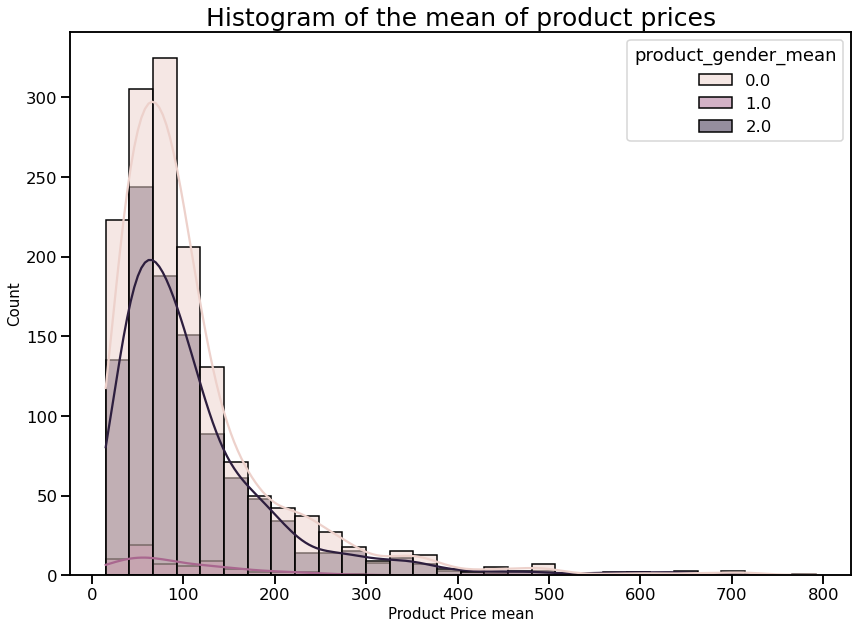

In [12]:
plt.figure(figsize=(14, 10))

sns.set_context('talk')
sns.histplot(data=df_eda, x='product_price_mean', bins=30, hue='product_gender_mean', kde=True)
plt.title("Histogram of the mean of product prices", fontsize=25)
plt.xlabel("Product Price mean", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

The above histogram shows the distribution of the quantity of average product prices divided by the sex of the person making the purchase (hue). We can observe that the graph looks similar for each group. Regardless of gender, most values are in the ` $ 0 ` - ` $ 150 ` range. Users are reluctant to buy more expensive products. As the price increases, the number of values belonging to each bin decreases.

## Box plot

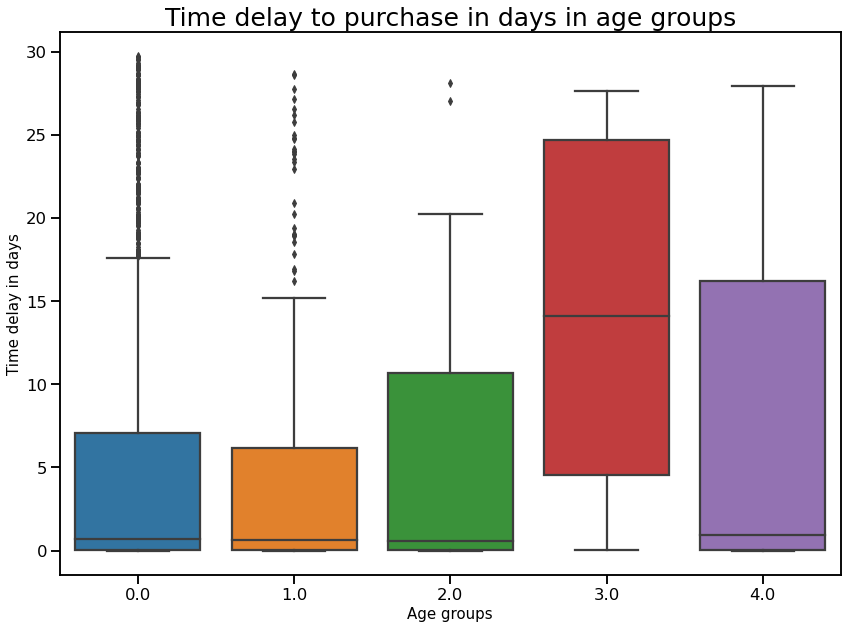

In [13]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.boxplot(x='product_age_group_mean', y='time_delay_days', data=df_eda)
plt.title("Time delay to purchase in days in age groups", fontsize=25)
plt.xlabel("Age groups", fontsize=15)
plt.ylabel("Time delay in days", fontsize=15)
plt.show()

The above box chart shows the time between clicking on the ad and becoming a customer in the store by purchasing the product. Time is expressed in days. For four of the five groups, the median waiting time is approximately less than a day. For groups no. 0 and no. 1, a lot of outliers can be observed. The group no.3 differs most from the other groups, for which the median of this value is almost 15 days, and also the 1st and 3rd quartiles are significantly different from the other observed groups.


Thanks to this chart, it can be concluded that people from group 3 make purchases more responsibly than the rest - they spend more time checking the product and do not make purchases on the spur of the moment.

It is also worth checking how many people belong to each group. For this we will use a bar chart.

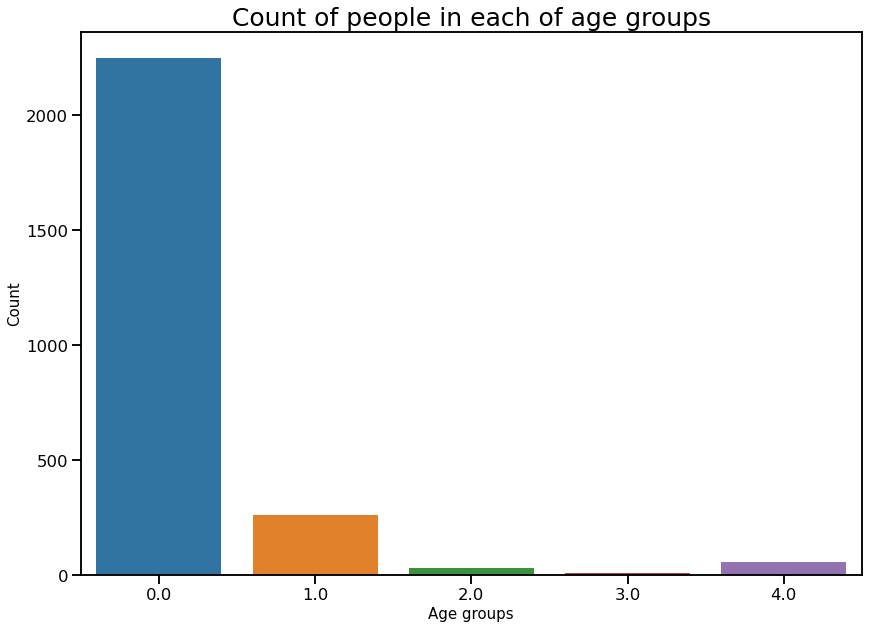

In [14]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.countplot(x='product_age_group_mean', data=df_eda)
plt.title("Count of people in each of age groups", fontsize=25)
plt.xlabel("Age groups", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

The bar chart presented above slightly changes the perception of the previous plot - the box plot. It turns out that comparing delay times in different age groups may be a bit unreliable due to the large difference in the number of people in each group. Definitely most people belong to the zero group, and the least to the third group. This may be one of the reasons for the previously observed differences in time between clicking and becoming a customer.

# 3. TESTING HYPOTHESES

## Correlation test

The higher the price of the product, the higher the cost for the user. Hence, the user should consider whether it is really profitable to spend money. So the time between clicking on the ad and buying an item should be longer for more expensive items.

The first test to be carried out will therefore be the test for the correlation of the variables time_delay_days and product_price_mean.

HYPOTHESES:

$ H_0 : \rho = 0 $

$ H_1 : \rho != 0 $

In [15]:
time = df_eda.time_delay_days
price = df_eda.product_price_mean
alpha = 0.05
n = len(time)

covariance = np.cov(time, price, ddof=1)[0, 1]
correlation = covariance/(np.std(time, ddof=1)*np.std(price, ddof=1))

print(f'Covariance: {covariance:.3f}')
print(f'Correlation: {correlation:.3f}')

crit_value = t.ppf(1-alpha/2, n-2)
T = correlation*np.sqrt(n-2) / np.sqrt(1 - correlation**2)
print(f'Critical value: {crit_value:.3f}')
print(f't value: {T:.3f}')

Covariance: 40.675
Correlation: 0.057
Critical value: 1.961
t value: 2.948


We can observe that although the correlation is not zero, its value is very close to zero. This means that the linear relationship between these variables is very low. For a better understanding, let's plot these two variables using a scatter plot.

### Plot

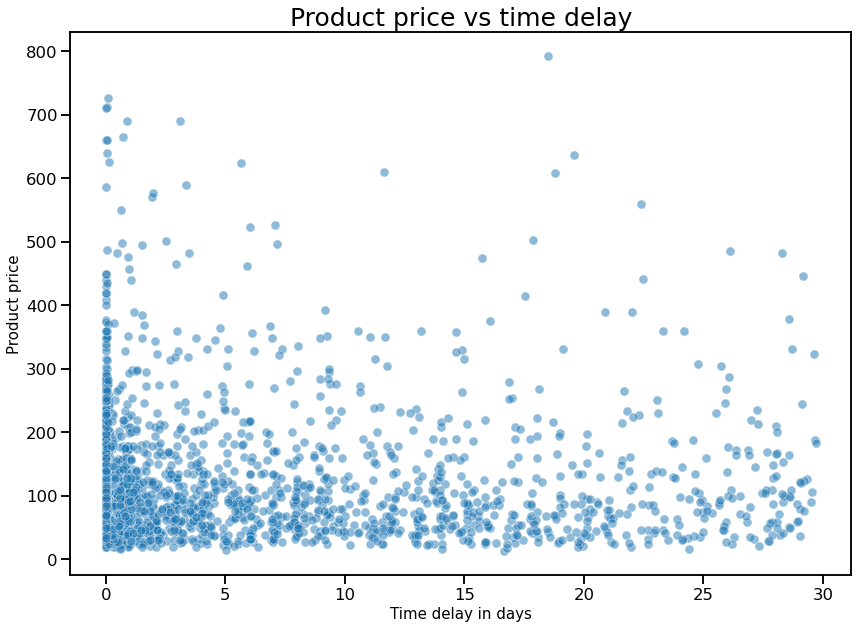

In [16]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.scatterplot(x='time_delay_days', y='product_price_mean', data=df_eda, alpha=0.5)
plt.title("Product price vs time delay", fontsize=25)
plt.xlabel("Time delay in days", fontsize=15)
plt.ylabel("Product price", fontsize=15)
plt.show()

The chart clearly shows that, virtually regardless of the price of the product, in most cases the purchase is made immediately.

## Two-Sample test

The next performed test will be a Two-Sample test. The first sample will be purchases made from August 4, 2020 to September 15, 2020, and the second sample will be purchases made from September 16, 2020 to November 2, 2020. First, we will divide our whole dataset into these two groups.

Thanks to this test, we will check whether the every 3 days average purchases in the second period of time were different from the every 3 days average purchases in the first period. For this we will use the 'SalesAmountInEuro_sum' column.

In [17]:
# create dataframe with week averages
df_two_sample = df_eda[['day', 'SalesAmountInEuro_sum']]
df_two_sample.day = pd.to_datetime(df_two_sample.day)
df_two_sample.set_index('day', inplace=True)
df_week_avg = df_two_sample.groupby(pd.Grouper(freq='3D')).mean()
df_week_avg.reset_index(inplace=True)

df_sample_1 = df_week_avg[df_week_avg['day'] < dt.datetime(2020, 9, 16)]
df_sample_2 = df_week_avg[df_week_avg['day'] >= dt.datetime(2020, 9, 16)]

sample_1 = df_sample_1.SalesAmountInEuro_sum
sample_2 = df_sample_2.SalesAmountInEuro_sum

To properly perform this test, we must first check that the samples are normally distributed, as this is one of the test's assumptions. For this we will use the Shapiro-Wilk test. We will perform it using the built-in tool from the scipy library.
The hypotheses for this test are as follows:

$ H_0 $ The sample comes from a normally distributed population

$ H_1 $ The sample does not come from a normally distributed population.

In [18]:
print(shapiro(sample_1))
print(shapiro(sample_2))

ShapiroResult(statistic=0.94046950340271, pvalue=0.3883109390735626)
ShapiroResult(statistic=0.9335607290267944, pvalue=0.2774386405944824)


With the significance level alpha = 0.05, we can not reject the null hypothesis.

So we can proceed to the test of two samples.


HYPOTHESES:

$ \mu_1 = \mu_2 $

$ \mu_1 != \mu_2 $

In [19]:
alpha = 0.05
sample_1 = df_sample_1.SalesAmountInEuro_sum
sample_2 = df_sample_2.SalesAmountInEuro_sum

n1 = len(sample_1)
n2 = len(sample_2)
mu1 = np.mean(sample_1)
mu2 = np.mean(sample_2)
s1_squared = np.var(sample_1, ddof=1)
s2_squared = np.var(sample_2, ddof=1)

Z = (mu1-mu2)/np.sqrt((s1_squared/n1 + s2_squared/n2))
print(f'Z value {Z:.3f}')
print(f'Critical values: {-norm.ppf(1-alpha/2)}, {norm.ppf(1-alpha/2)}')

Z value -3.573
Critical values: -1.959963984540054, 1.959963984540054


The value of the Z statistic is outside the critical area, so we can reject the null hypothesis and adopt a new hypothesis. This means that the average values of purchases in these two time samples differed from each other.

Let's take a look at how the values look on the chart.

### Plot

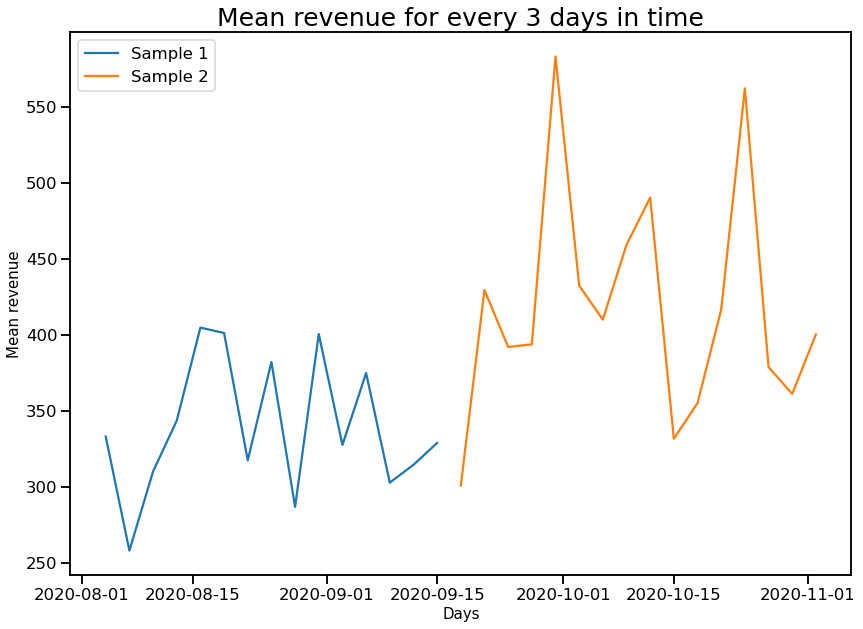

In [20]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.lineplot(x='day', y='SalesAmountInEuro_sum', data=df_sample_1, label='Sample 1')
sns.lineplot(x='day', y='SalesAmountInEuro_sum', data=df_sample_2, label='Sample 2')
plt.title("Mean revenue for every 3 days in time", fontsize=25)
plt.xlabel("Days", fontsize=15)
plt.ylabel("Mean revenue", fontsize=15)

plt.show()

As we can see, the values in the second sample are significantly different from those in the first sample.

# 4. FEATURE ENGINEERING

## Deep Feature Synthesis

The chosen method of feature engineering is Deep Feature Synthesis. It is an algorithm that allows you to automatically generate features in relational data sets. The algorithm follows the relationships in the data set and creates new features based on these relationships. Due to the fact that features are created with the help of previously created ones, each feature has a given depth. For more information head over to the [official documentation](https://featuretools.alteryx.com/en/stable/getting_started/afe.html).

To use Deep Feature Synthesis we will use dataset `df_nans_encoded` defined before. We will divide it into appropriate smaller datasets, and then connect them with keys. Everything will be done with featuretools package.

## Creating EntitySet without categorical features

First, we will create an EntitySet with no categorical variables. EntitySet is a data structure that represents a collection of tables and the connections between them. Let's initiate the EntitySet `es_nc` - entity set non categorical.

In [21]:
es1 = ft.EntitySet(id=PARTNER_ID)

### Creating dataframes

Now we need to properly prepare each of the datasets that will be included in the defined EntitySet. There will be 5 such datasets. Corresponding descriptions for each of the datasets are provided in the code.

In [22]:
# Products
# Each of the products has a price.
PRODUCT_INFO_NC = ['product_id', 'product_price']
df_products_nc = df_nans_encoded[PRODUCT_INFO_NC]
df_products_nc.drop_duplicates(subset=['product_id'], inplace=True)

# Days
# Each day has the total number of purchased goods,
# average and total revenue,
# average and total waiting time,
# average and total value of sold products
df_days_nc = df_nans_encoded.groupby('day').agg({'Sale': 'size',
                                                'SalesAmountInEuro': ['mean', 'sum'],
                                                'time_delay_for_conversion': ['mean', 'sum'],
                                                'product_price': ['mean', 'sum']})
df_days_nc.columns = ['_'.join(temp).strip('_') for temp in df_days_nc.columns.to_flat_index()]
df_days_nc.reset_index(inplace=True)

# Users
# Each user has the total number of purchased goods,
# average and total revenue,
# average and total waiting time,
# average and total value of sold products
df_users_nc = df_nans_encoded.groupby('user_id').agg({'Sale': 'size',
                                                     'SalesAmountInEuro': ['mean', 'sum'],
                                                     'time_delay_for_conversion': ['mean', 'sum'],
                                                     'product_price': ['mean', 'sum']})
df_users_nc.columns = ['_'.join(temp).strip('_') for temp in df_users_nc.columns.to_flat_index()]
df_users_nc.reset_index(inplace=True)

# Transactions
# Each transaction has a day,
# product id,
# user id,
# revenue generated,
# waiting time,
# exact click time,
# average number of clicks for this product per week
df_transactions_nc = df_nans_encoded[['day', 'product_id', 'user_id',
                                     'SalesAmountInEuro', 'time_delay_for_conversion',
                                     'click_timestamp', 'nb_clicks_1week']]
df_transactions_nc['transaction_id'] = np.arange(1, len(df_transactions_nc)+1)

# Pairs
# Clicks for a given product on a given day have been collected in dataset pairs.
# The number of such events and the total purchase revenue were calculated for each line.
df_days_products_nc = df_nans_encoded.groupby(['day', 'product_id']).agg({'Sale': 'size', 'SalesAmountInEuro': 'sum'})
df_days_products_nc.rename({'Sale': 'number_of_sales', 'SalesAmountInEuro': 'SalesAmountInEuro_sum'}, axis=1, inplace=True)
df_days_products_nc['pair_id'] = np.arange(1, len(df_days_products_nc)+1)
df_days_products_nc.reset_index(inplace=True)

### Creating EntitySet from dataframes

Now that we have created the appropriate datasets, we are ready to merge them into an EntitySet.

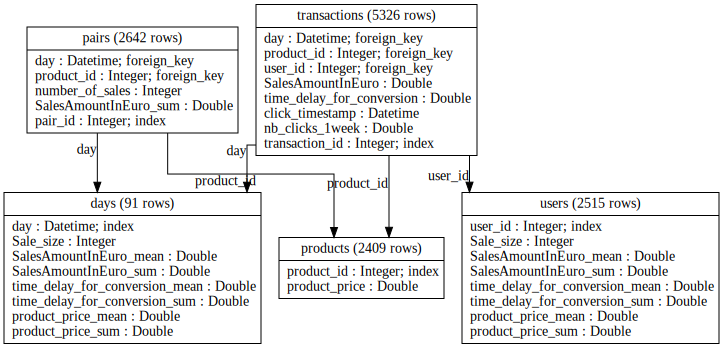

In [23]:
es1 = es1.add_dataframe(
    dataframe_name="transactions",
    dataframe=df_transactions_nc,
    index="transaction_id", # The index parameter specifies the column that uniquely identifies rows in the dataframe
)

es1 = es1.add_dataframe(
    dataframe_name="products",
    dataframe=df_products_nc,
    index="product_id",
)

es1 = es1.add_dataframe(
    dataframe_name="users",
    dataframe=df_users_nc,
    index='user_id'
)

es1 = es1.add_dataframe(
    dataframe_name="days",
    dataframe=df_days_nc,
    index='day'
)

es1 = es1.add_dataframe(
    dataframe_name="pairs",
    dataframe=df_days_products_nc,
    index='pair_id'
)

es1 = es1.add_relationship("products", "product_id", "transactions", "product_id")
es1 = es1.add_relationship("users", "user_id", "transactions", "user_id")
es1 = es1.add_relationship("days", "day", "transactions", "day")
es1 = es1.add_relationship("days", "day", "pairs", "day")
es1 = es1.add_relationship("products", "product_id", "pairs", "product_id")

es1.plot()

## DFS for EntitySet without categorical features

After creating the EntitySet, we can start using the Deep Feature Synthesis algorithm.

Thanks to the featuretools package it is easy to do. Through the `target_dataframe_name` argument, we define for which table we want to calculate additional features.

Thanks to the magic `%time` command, we will be able to measure the execution time of the algorithm. The greater the value of the `max_depth` argument, the longer it takes to execute.

In [24]:
# %%time
# feature_matrix, feature_defs = ft.dfs(entityset=es1,
#                                       target_dataframe_name="pairs",
#                                       max_depth=5)
# feature_matrix

Let's save the created feature_matrix to a csv file.

In [25]:
# feature_matrix.to_csv(f'FeatureMatrixNoCategorical_{PARTNER_ID}.csv')

## Create EntitySet with categorical features

Now we will perform operations similar to those in the previous points, but also using categorical variables.

We'll start by defining a new EntitySet.

In [26]:
es2 = ft.EntitySet(id=PARTNER_ID)

### Creating dataframes

Dataframes will look in the same way as before - except for `products`

In [27]:
# Products
PRODUCT_INFO = ['product_age_group', 'device_type', 'product_gender', 'product_brand',
                'product_category(1)', 'product_category(2)', 'product_category(3)', 'product_category(4)',
                'product_category(5)', 'product_category(6)', 'product_category(7)',
                'product_country', 'product_id', 'product_title', 'product_price']
df_products = df_nans_encoded[PRODUCT_INFO]
df_products.drop_duplicates(subset=['product_id'], inplace=True)

# Days
df_days = df_nans_encoded.groupby('day').agg({'Sale': 'size',
                                              'SalesAmountInEuro': ['mean', 'sum'],
                                              'time_delay_for_conversion': ['mean', 'sum'],
                                              'product_price': ['mean', 'sum']})
df_days.columns = ['_'.join(temp).strip('_') for temp in df_days.columns.to_flat_index()]
df_days.reset_index(inplace=True)

# Users
df_users = df_nans_encoded.groupby('user_id').agg({'Sale': 'size',
                                                   'SalesAmountInEuro': ['mean', 'sum'],
                                                   'time_delay_for_conversion': ['mean', 'sum'],
                                                   'product_price': ['mean', 'sum']})
df_users.columns = ['_'.join(temp).strip('_') for temp in df_users.columns.to_flat_index()]
df_users.reset_index(inplace=True)

# Transactions
df_transactions = df_nans_encoded[['day', 'product_id', 'user_id',
                                   'SalesAmountInEuro', 'time_delay_for_conversion',
                                   'click_timestamp', 'nb_clicks_1week']]
df_transactions['transaction_id'] = np.arange(1, len(df_transactions)+1)

# Pairs
df_days_products = df_nans_encoded.groupby(['day', 'product_id']).agg({'Sale': 'size',
                                                                       'SalesAmountInEuro': 'sum'})
df_days_products.rename({'Sale': 'number_of_sales',
                         'SalesAmountInEuro': 'SalesAmountInEuro_sum'},
                        axis=1,
                        inplace=True)
df_days_products['pair_id'] = np.arange(1, len(df_days_products)+1)
df_days_products.reset_index(inplace=True)

In order for the qualitative data to be correctly taken into account when carrying out the DFS algorithm, it will be necessary to give them a special Categorical type defined in the woodwork package

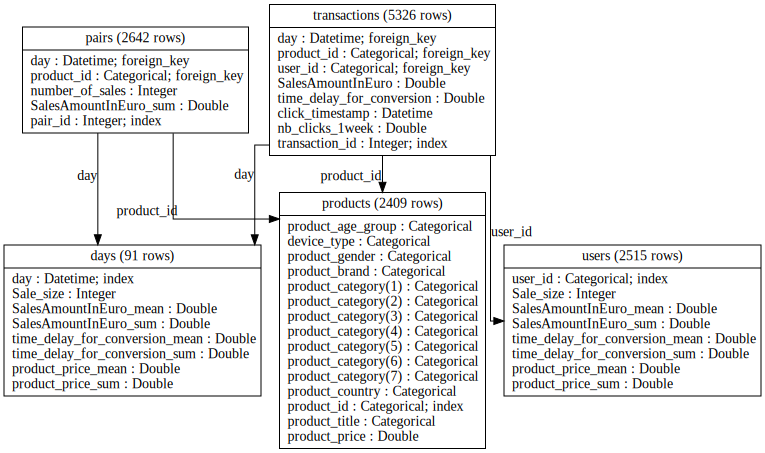

In [28]:
categorical_type_columns_products = ['product_age_group', 'device_type', 'product_gender', 'product_brand',
                                   'product_category(1)', 'product_category(2)', 'product_category(3)', 'product_category(4)',
                                   'product_category(5)', 'product_category(6)', 'product_category(7)',
                                   'product_country', 'product_id', 'product_title']
categorical_type_columns_products = {column: Categorical for column in categorical_type_columns_products}

es2 = es2.add_dataframe(
    dataframe_name="transactions",
    dataframe=df_transactions,
    index="transaction_id",
    logical_types={
        "product_id": Categorical,
        "user_id": Categorical,
    }
)

es2 = es2.add_dataframe(
    dataframe_name="products",
    dataframe=df_products,
    index="product_id",
    logical_types=categorical_type_columns_products
)

es2 = es2.add_dataframe(
    dataframe_name="users",
    dataframe=df_users,
    index='user_id',
    logical_types={
        'user_id': Categorical,
    }
)

es2 = es2.add_dataframe(
    dataframe_name="days",
    dataframe=df_days,
    index='day'
)

es2 = es2.add_dataframe(
    dataframe_name="pairs",
    dataframe=df_days_products,
    index='pair_id',
    logical_types={
        'product_id': Categorical
    }
)

es2 = es2.add_relationship("products", "product_id", "transactions", "product_id")
es2 = es2.add_relationship("users", "user_id", "transactions", "user_id")
es2 = es2.add_relationship("days", "day", "transactions", "day")
es2 = es2.add_relationship("days", "day", "pairs", "day")
es2 = es2.add_relationship("products", "product_id", "pairs", "product_id")

es2.plot()

In [29]:
# %%time
# feature_matrix2, feature_defs2 = ft.dfs(entityset=es2,
#                                       target_dataframe_name="pairs",
#                                       max_depth=5)
# feature_matrix2

Let's save the created feature_matrix to a csv file.

In [30]:
# feature_matrix2.to_csv(f"FeatureMatrixCategorical_{PARTNER_ID}.csv")

# 5. STATISTICAL TESTING OF DESCRIPTIVE FEATURES

In this part of the notebook, we will test the correlation between the described variable - the sum of the values in the SalesAmountInEuro column on a given day for a given product_id value and the describing variables.

We will count how many such variables are significantly correlated with the variable described for a dataset without categorical variables and for a dataset containing categorical variables.

## No Categorical

We'll start with a dataset that does not contain categorical variables. After loading the dataset from the file, we remove the columns with the values of inf, -inf and NaN. There aren't many of these columns, so we're not losing a lot of information.

In [31]:
df1 = pd.read_csv(f"FeatureMatrixNoCategorical_{PARTNER_ID}.csv")
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(axis=1, inplace=True)
df1.head()

,pair_id,product_id,number_of_sales,SalesAmountInEuro_sum,DAY(day),MONTH(day),WEEKDAY(day),YEAR(day),days.Sale_size,days.SalesAmountInEuro_mean,...,days.SUM(transactions.products.NUM_UNIQUE(transactions.YEAR(click_timestamp))),days.SUM(transactions.products.NUM_UNIQUE(transactions.YEAR(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.DAY(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.DAY(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.MONTH(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.MONTH(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.WEEKDAY(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.WEEKDAY(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.YEAR(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.YEAR(day)))
0,1,1068,2,580.000,4,8,1,2020,4,202.000,...,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000
1,2,2326,2,228.000,4,8,1,2020,4,202.000,...,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000
2,3,19,2,254.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
3,4,32,2,178.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
4,5,132,2,194.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000


### Correlation test

The performed correlation test for each of the describing variables will allow to determine how many variables are significantly correlated at the significance level of 0.05.

In [32]:
SalesSum = df1.SalesAmountInEuro_sum
n = len(SalesSum)
alpha = 0.05
counter = 0 # counts correlated columns
crit_value1 = t.ppf(alpha/2, n-2) # lower critical value
crit_value2 = t.ppf(1-alpha/2, n-2) # upper critical value

for col in df1.columns.drop(['pair_id', 'product_id', 'SalesAmountInEuro_sum']):
    temp_col = df1[col]

    covariance = np.cov(temp_col, SalesSum, ddof=1)[0, 1]
    correlation = covariance/(np.std(temp_col, ddof=1)*np.std(SalesSum, ddof=1))

    # T value
    T = correlation*np.sqrt(n-2) / np.sqrt(1 - correlation**2)

    if  T < crit_value1 or T > crit_value2:
        counter += 1

print(f"Counter: {counter}")

Counter: 203


The `counter` variable determines how many variables are significantly correlated with the described variable.

## Categorical

We perform the same operations for a dataset which contains categorical variables.

In [33]:
df2 = pd.read_csv(f"FeatureMatrixCategorical_{PARTNER_ID}.csv")
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.dropna(axis=1, inplace=True)
df2.head()

,pair_id,product_id,number_of_sales,SalesAmountInEuro_sum,DAY(day),MONTH(day),WEEKDAY(day),YEAR(day),days.Sale_size,days.SalesAmountInEuro_mean,...,days.SUM(transactions.products.NUM_UNIQUE(transactions.YEAR(click_timestamp))),days.SUM(transactions.products.NUM_UNIQUE(transactions.YEAR(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.DAY(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.DAY(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.MONTH(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.MONTH(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.WEEKDAY(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.WEEKDAY(day))),days.SUM(transactions.users.NUM_UNIQUE(transactions.YEAR(click_timestamp))),days.SUM(transactions.users.NUM_UNIQUE(transactions.YEAR(day)))
0,1,1068,2,580.000,4,8,1,2020,4,202.000,...,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000
1,2,2326,2,228.000,4,8,1,2020,4,202.000,...,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000
2,3,19,2,254.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
3,4,32,2,178.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000
4,5,132,2,194.000,5,8,2,2020,34,139.471,...,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000,34.000


### Correlation test

In [34]:
SalesSum = df2.SalesAmountInEuro_sum
n = len(SalesSum)
alpha = 0.05
counter = 0 # counts correlated columns
crit_value1 = t.ppf(alpha/2, n-2) # lower critical value
crit_value2 = t.ppf(1-alpha/2, n-2) # upper critical value

for col in df2.columns.drop(['pair_id', 'product_id', 'SalesAmountInEuro_sum']):
    temp_col = df2[col]

    covariance = np.cov(temp_col, SalesSum, ddof=1)[0, 1]
    correlation = covariance/(np.std(temp_col, ddof=1)*np.std(SalesSum, ddof=1))

    # T value
    T = correlation*np.sqrt(n-2) / np.sqrt(1 - correlation**2)

    if  T < crit_value1 or T > crit_value2:
        counter += 1

print(f"Counter: {counter}")

Counter: 207


The final result is 207 variables significantly correlated with the described variable.

# 6. PCA

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

To perform PCA on a dataset that does not contain categorical variables obtained using DFS, we will use the PCA class implemented in the scikit-learn package.

## Standard scaler

Before using PCA, we will extract particular subset and standardize the entire subset as PCA is sensitive to the scale of values.

In [35]:
standard_scaler = StandardScaler()
y = df1.SalesAmountInEuro_sum.to_numpy()
X = df1.drop(['pair_id', 'SalesAmountInEuro_sum', 'product_id'], axis=1)
df1_scaled = standard_scaler.fit_transform(X)
df1_scaled

array([[-0.08550089, -1.35723081, -1.2626014 , ..., -3.10278361,
        -3.12327866, -3.12327866],
       [-0.08550089, -1.35723081, -1.2626014 , ..., -3.10278361,
        -3.12327866, -3.12327866],
       [-0.08550089, -1.24270132, -1.2626014 , ..., -1.70984199,
        -1.5673323 , -1.5673323 ],
       ...,
       [-0.08550089, -1.58628979,  2.4617673 , ..., -2.54560696,
        -2.50090012, -2.50090012],
       [-0.08550089, -1.58628979,  2.4617673 , ..., -2.54560696,
        -2.50090012, -2.50090012],
       [-0.08550089, -1.58628979,  2.4617673 , ..., -2.54560696,
        -2.50090012, -2.50090012]])

## Using PCA

To select the appropriate number of target subspaces, we will draw the explained variance ratio graph and use it to make our selection.

In [36]:
pca = PCA()
pca.fit(df1_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

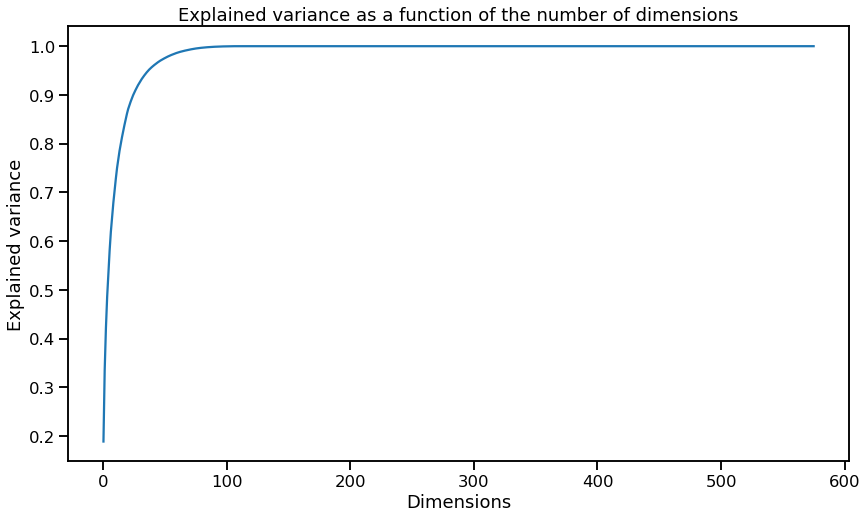

In [37]:
plt.figure(figsize=(14, 8))
plt.plot(cumsum)
plt.title("Explained variance as a function of the number of dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Explained variance")
plt.show()

We can see that reducing the dimensionality down to 40 wouldn't lose too much explained variance.

In [38]:
pca = PCA(n_components=40)
X_reduced = pca.fit_transform(X)
X_reduced

array([[-1.39556190e+08,  9.72250453e+06,  5.08193330e+06, ...,
        -4.91776499e+03,  9.30111149e+03, -5.86391121e+03],
       [-1.39556788e+08,  9.72193643e+06,  5.08294718e+06, ...,
        -4.92041036e+03,  9.29933790e+03, -5.85887120e+03],
       [-1.12801151e+08,  8.34015336e+06,  2.20059421e+06, ...,
        -5.09714743e+03,  1.28344820e+02, -2.45378224e+03],
       ...,
       [-1.18450843e+08,  6.90242439e+06,  3.87772011e+06, ...,
         5.83104120e+03,  1.26190455e+04,  1.03417576e+04],
       [-1.18447744e+08,  6.90536996e+06,  3.87246314e+06, ...,
         5.82839510e+03,  1.26211511e+04,  1.03395096e+04],
       [-1.18459723e+08,  6.89398258e+06,  3.89278622e+06, ...,
         5.84042653e+03,  1.26159541e+04,  1.03477895e+04]])

This is what a dataset looks like after reducing its dimensions to 40. Its dimensions are also presented below.

In [39]:
X_reduced.shape

(2642, 40)

## Correlation test

The following test is a test of the correlation between the described variable and the variables obtained as a result of the PCA algorithm.


HYPOTHESES:

$ H_0 : \rho = 0 $

$ H_1 : \rho != 0 $

In [43]:
n = len(SalesSum)
alpha = 0.05
counter = 0 # counts correlated columns
crit_value1 = t.ppf(alpha/2, n-2) # lower critical value
crit_value2 = t.ppf(1-alpha/2, n-2) # upper critical value

for column in X_reduced.T:
    
    covariance = np.cov(column, y, ddof=1)[0, 1]
    correlation = covariance/(np.std(column, ddof=1)*np.std(y, ddof=1))
    
    # T value
    T = correlation*np.sqrt(n-2) / np.sqrt(1 - correlation**2)

    if  T < crit_value1 or T > crit_value2:
        counter += 1
        
print(f"Counter: {counter}")

Counter: 7


Thanks to the test, we know that 7 out of 40 selected features are significantly correlated with the described variable.

# 7. SUMMARY

This notebook covers Exploratory Analysis + Feature Engineering Elements + Test of Correlation Coefficients using Criteo Data Search data.

**Motivations for choices made during work:**

During the work, I focused mainly on the analysis of the numerical values contained in the SalesAmountInEuro and product_price columns with divisions into different subgroups, because they were later taken into account in the correlation tests. It was also easy to present these features in graphs due to their quantitative nature. Most of the data in the dataset was categorical.

Unfortunately, a large amount of data had to be omitted from the considerations due to the lack of information in many fields (NaN). Thanks to this, however, I was able to get acquainted with the work with a previously unprepared data set.

I decided to group the data in such a way that it is possible to carry out tests on them and to make a sensible and clear data visualization.

**Conclusions**

The Deep Feature Synthesis algorithm is a tool that can be of great help in training machine learning models. Thanks to it, you can create many new features that are not present in the original dataset, and which may turn out to be crucial when training the model.

Thanks to the PCA algorithm, we can significantly reduce the multidimensionality of data without losing a lot of information.

**Suggestions for further steps**

The presented notebook contains work on only a small part of the entire Criteo Data Search dataset. If I were to take the next steps, I would also consider other product manufacturers and compare them with each other. Given the size of the entire dataset, a machine learning model could also be trained to predict the price of a product based on its characteristics.

# 8. LITERATURE


**BOOKS** :
- Hands-On Machine Learning with Scikit-Learn and TensorFlow - Aurelien Geron
- Practical Statistics for Data Scientists: 50+ Essential Concepts Using R and Python, 2nd Edition - Peter Bruce, Andrew Bruce, Peter Gedeck

**LINKS** :

INTRODUCTION
- https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

EXPLORATORY DATA ANALYSIS
- https://stackoverflow.com/questions/34317149/pandas-groupby-with-bin-counts
- https://seaborn.pydata.org/generated/seaborn.histplot.html
- https://en.wikipedia.org/wiki/Frequency_(statistics)
- https://en.wikipedia.org/wiki/Exploratory_data_analysis
- https://en.wikipedia.org/wiki/Summary_statistics

TESTING HYPOTHESES
- https://pl.wikipedia.org/wiki/Test_Shapiro-Wilka
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
- http://www.sthda.com/english/wiki/correlation-test-between-two-variables-in-r

FEATURE ENGINEERING
- https://medium.com/@souvikmanna251/deep-feature-synthesis-introduction-to-feature-engineering-49438cdc143e
- https://medium.com/@souvikmanna251/deep-feature-synthesis-introduction-to-feature-engineering-7977f626359f
- https://towardsdatascience.com/deep-feature-synthesis-vs-genetic-feature-generation-6ba4d05a6ca5
- https://featuretools.alteryx.com/en/stable/index.html#

PCA
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://www.keboola.com/blog/pca-machine-learning
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html